In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

def parse_visu_signal_log(file_path):
    path = Path(file_path)
    # print(f"🚦 Parsing {path.name}...")
    
    with path.open('r', encoding='latin1') as f:
        header_lines = [f.readline() for _ in range(8)]
        
    # extract Type (T, V, B) and ID (1, 2, 3)
    row_types_str = header_lines[4].strip() 
    row_ids_str   = header_lines[5].strip()
    
    types_list = row_types_str.split()
    ids_list   = row_ids_str.split()
    
    # --- FIX: Match CSV format (e.g. "T1", "V14") ---
    real_col_names = ['Date', 'Time']
    name_counts = defaultdict(int)
    
    for t, i in zip(types_list, ids_list):
        # Concatenate directly: "T" + "1" -> "T1"
        base_name = f"{t}{i}" 
        
        if name_counts[base_name] > 0:
            count = name_counts[base_name] + 1
            unique_name = f"{base_name}_{count}" # Duplicate handling
        else:
            unique_name = base_name
            
        name_counts[base_name] += 1
        real_col_names.append(unique_name)

    # Add dummy columns for garbage
    dummy_cols = [f"Junk_{i}" for i in range(50)]
    all_col_names = real_col_names + dummy_cols
    
    # Read Data
    try:
        df = pd.read_csv(
            path, 
            skiprows=8, 
            sep=r'\s+', 
            engine='python', 
            header=None,
            names=all_col_names,
            encoding='latin1',
            dtype=str
        )
    except Exception as e:
        print(f"   ❌ Failed to read {path.name}: {e}")
        return None
    
    # Clean Up
    df.drop(columns=dummy_cols, inplace=True)
    df = df[df['Date'].str.contains(r'\d', na=False)].copy()
    
    df['timestamp'] = pd.to_datetime(
        df['Date'] + ' ' + df['Time'], 
        dayfirst=True, 
        errors='coerce'
    )
    df.dropna(subset=['timestamp'], inplace=True)
    df = df.set_index('timestamp').drop(columns=['Date', 'Time'])
    
    # Decode: 3=Red(1), 48=Green(0), Others=Green(0)
    # Based on your feedback: 48 is VERT (Green)
    def decode_visu(val):
        try:
            x = int(val)
            if x == 3: return 1  # RED (STOP)
            if x in [1, 2, 5, 7, 11, 12, 15, 48]: return 0 # GREEN (GO)
            return 1 # Unknown -> Default to Penalty
        except:
            return 1 
            
    df = df.applymap(decode_visu).astype(np.int8)
    return df

In [3]:
df_signals = parse_visu_signal_log("../data/carrefours-PIVOT/GE_17/K17_251113_07.00-09.00_HPM.txt")

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


In [4]:
import os

# 1. Load your Intersection Metadata
carrefour_df = pd.read_csv("../data/all_carrefour_merged.csv")

# 2. Extract Unique Intersection IDs (Integers)
#    17.0 -> 17, 17.1 -> 17
unique_ids = carrefour_df['numero_carrefour'].dropna().astype(float).astype(int).unique()
print(f"Found {len(unique_ids)} unique intersections in CSV.")

# 3. Define Root Data Path
SIGNAL_ROOT = Path("../data/carrefours-PIVOT")
OUTPUT_DB_DIR = Path("../data/signal_parquet_db")
OUTPUT_DB_DIR.mkdir(exist_ok=True)

# 4. Loop and Process
for cid in unique_ids:
    folder_name = f"GE_{cid}"
    folder_path = SIGNAL_ROOT / folder_name
    
    if not folder_path.exists():
        # print(f"⚠️ No signal data folder for Intersection {cid} (GE_{cid})")
        continue
        
    print(f"📂 Processing Intersection {cid}...")
    
    # Find all .txt files in this folder (HPM, HPS, etc.)
    txt_files = list(folder_path.glob("*.txt"))
    
    if not txt_files:
        print(f"   No .txt files found in {folder_name}")
        continue
        
    # Parse and Accumulate
    dfs = []
    for txt_file in txt_files:
        df_part = parse_visu_signal_log(txt_file)
        if df_part is not None and not df_part.empty:
            dfs.append(df_part)
            
    if dfs:
        # Concatenate all time periods (AM + PM)
        full_df = pd.concat(dfs).sort_index()
        
        # Remove duplicate timestamps (if files overlap)
        full_df = full_df[~full_df.index.duplicated(keep='first')]
        
        # Save to Parquet
        out_file = OUTPUT_DB_DIR / f"signal_{cid}.parquet"
        full_df.to_parquet(out_file)
        print(f"   ✅ Saved {len(full_df)} rows to {out_file.name}")
        
        # QC: Check if columns match CSV expectations
        # valid_signals = carrefour_df[carrefour_df['numero_carrefour'].astype(int) == cid]['groupe_de_feux'].unique()
        # print(f"      CSV expects: {valid_signals}")
        # print(f"      Log contains: {list(full_df.columns[:5])}...")
    else:
        print("   ❌ No valid data parsed.")

print("DONE. Signal Database Built.")

Found 371 unique intersections in CSV.
📂 Processing Intersection 45...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_45.parquet
📂 Processing Intersection 40...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(


   ✅ Saved 14400 rows to signal_40.parquet
📂 Processing Intersection 27...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14401 rows to signal_27.parquet
📂 Processing Intersection 17...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_17.parquet
📂 Processing Intersection 5...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_5.parquet
📂 Processing Intersection 168...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_168.parquet
📂 Processing Intersection 99...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_99.parquet
📂 Processing Intersection 140...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_140.parquet
📂 Processing Intersection 246...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_246.parquet
📂 Processing Intersection 65...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_65.parquet
📂 Processing Intersection 49...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_49.parquet
📂 Processing Intersection 31...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_31.parquet
📂 Processing Intersection 560...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_560.parquet
📂 Processing Intersection 21...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_21.parquet
📂 Processing Intersection 226...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_226.parquet
📂 Processing Intersection 222...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_222.parquet
📂 Processing Intersection 47...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_47.parquet
📂 Processing Intersection 42...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_42.parquet
📂 Processing Intersection 69...
   No .txt files found in GE_69
📂 Processing Intersection 76...
   No .txt files found in GE_76
📂 Processing Intersection 68...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_68.parquet
📂 Processing Intersection 275...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14401 rows to signal_275.parquet
📂 Processing Intersection 97...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14404 rows to signal_97.parquet
📂 Processing Intersection 87...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_87.parquet
📂 Processing Intersection 81...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_81.parquet
📂 Processing Intersection 80...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_80.parquet
📂 Processing Intersection 100...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_100.parquet
📂 Processing Intersection 15...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14400 rows to signal_15.parquet
📂 Processing Intersection 268...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


   ✅ Saved 14401 rows to signal_268.parquet
📂 Processing Intersection 20...
   No .txt files found in GE_20
📂 Processing Intersection 11...
   ✅ Saved 14400 rows to signal_11.parquet
DONE. Signal Database Built.


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/4229593554.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(decode_visu).astype(np.int8)


In [14]:
from pathlib import Path

HERE = Path.cwd().resolve()

PROJECT_ROOT = HERE if (HERE / "data").exists() else HERE.parent

RAW_PATH = PROJECT_ROOT / "data/stops_all_server.csv"  # or arrets_ben.csv
PARQUET_CACHE = PROJECT_ROOT / "data/stops_all_server.parquet"

def read_any_arrets(path: Path) -> pd.DataFrame:
    with path.open("r", encoding="utf-8-sig") as fh:
        first_line = fh.readline()
        second_line = fh.readline()

    looks_fixed_width = second_line and second_line.strip().startswith("-")

    if looks_fixed_width:
        # existing infer-colspecs + pd.read_fwf block
        return read_fixed_width(path, first_line, second_line)
    else:
        df = pd.read_csv(path, encoding="utf-8-sig")
        rename_map = {
            "Ligne": "C_Ligne",
            "SensAppl": "C_SensAppl",
            "DateCourse_course": "DateCourse",
            "HFermeturePortesReal": "HFermetureportesReal",
            "HEntreeFenetreArretReal": "DTEntreeFenetreArretReal",
            "HSortieFenetreArretReal": "DTSortieFenetreArretReal",
        }
        df = df.rename(columns=rename_map)
        return df

df_full = read_any_arrets(RAW_PATH)
df_full = df_full.loc[:, ~df_full.columns.duplicated()].copy()

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/1492456826.py:21: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding="utf-8-sig")


In [15]:
df_full.head()


,IdCourse,DateCourse,C_Ligne,LigneTxt,NumVoiture,ServiceVoiture,C_SensAppl,TypeTheo,IdVehicule,IdArret,...,DTSortieFenetreArretReal,HOuverturePortesReal,HFermetureportesReal,IdArretPrecedent,DistanceTheo,DExploitCourse,Longitude,Latitude,CodeLong,Arret
0,89604463,2025-11-01,1,1,10,1-10,A,0,195.0,5750.0,...,00:03:35,23:46:48,00:03:16,NaN,0.0,2025-10-31,6.214239,46.208679,HTCH02,HOPITAL 3-CHENE
1,89604463,2025-11-01,1,1,10,1-10,A,0,195.0,332.0,...,00:14:31,NaN,NaN,258.0,3573.0,2025-10-31,6.181599,46.205738,CMOL00,CLOS DU MOLAN
2,89604463,2025-11-01,1,1,10,1-10,A,0,195.0,8133.0,...,00:15:02,00:14:49,00:14:52,332.0,3852.0,2025-10-31,6.180379,46.204941,GRDL06,GRADELLE
3,89604463,2025-11-01,1,1,10,1-10,A,0,195.0,6845.0,...,00:16:24,00:16:03,00:16:13,8133.0,4356.0,2025-10-31,6.175099,46.203979,PRPI01,PRE-PICOT
4,89604463,2025-11-01,1,1,10,1-10,A,0,195.0,6823.0,...,00:17:35,00:17:02,00:17:15,6845.0,4803.0,2025-10-31,6.169679,46.202839,GEVV02,EAUX-VIVES-VADIE


In [19]:
# =========================
# Build `seg` (prev stop -> current stop) from df 
# =========================
import numpy as np
import pandas as pd

seg_src = df_full.copy()

# --- 0) Parse datetimes ---
time_cols = [
    "DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
]
for c in time_cols:
    if c in seg_src.columns:
        seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")

# --- 1) Basic casting / trimming ---
if "RangArretAsc" in seg_src.columns:
    seg_src["RangArretAsc"] = pd.to_numeric(seg_src["RangArretAsc"], errors="coerce")
if "C_Ligne" in seg_src.columns:
    seg_src["C_Ligne"] = pd.to_numeric(seg_src["C_Ligne"], errors="coerce")
seg_src["CodeLong"] = seg_src.get("CodeLong", "").astype(str).str.strip()
if "C_SensAppl" in seg_src.columns:
    seg_src["C_SensAppl"] = seg_src["C_SensAppl"].astype(str).str.strip()

# --- 2) Sort and build previous-stop columns (within a trip/course) ---
by = ["IdCourse","RangArretAsc"] if "IdCourse" in seg_src.columns else ["C_Ligne","DateCourse","RangArretAsc"]
seg_src = seg_src.sort_values(by, kind="mergesort")
grp = seg_src.groupby("IdCourse") if "IdCourse" in seg_src.columns else seg_src.groupby(["C_Ligne","DateCourse"])

seg_src["prev_CodeLong"] = grp["CodeLong"].shift(1)

# previous-window exit
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg_src.columns):
    seg_src["prev_DT_win_out"] = grp["DTSortieFenetreArretReal"].shift(1)
    seg_src["prev_DT_win_in"]  = grp["DTEntreeFenetreArretReal"].shift(1)
else:
    seg_src["prev_DT_win_out"] = np.nan
    seg_src["prev_DT_win_in"]  = np.nan


# --- 3) Keep only rows that have a previous stop (i.e., valid link) ---
seg = seg_src.dropna(subset=["prev_CodeLong"]).copy()
seg["from_stop"] = seg["prev_CodeLong"].astype(str).str.strip()
seg["to_stop"]   = seg["CodeLong"].astype(str).str.strip()
seg["SegmentKey"] = seg["from_stop"] + "→" + seg["to_stop"]



# 4b) Dwell Target (and 1-hop / 2-hop features)
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg.columns):
    seg["dwell_s"] = (seg["DTSortieFenetreArretReal"] - seg["DTEntreeFenetreArretReal"]).dt.total_seconds()
    seg.loc[(seg["dwell_s"]<0) | (seg["dwell_s"]>900), "dwell_s"] = np.nan
    
    # We must re-group on the 'seg' dataframe to lag dwell
    grp_seg = seg.groupby("IdCourse") if "IdCourse" in seg.columns else seg.groupby(["C_Ligne","DateCourse"])
    seg["dwell_prev_s"] = grp_seg["dwell_s"].shift(1)
    seg["dwell_prev_prev_s"] = grp_seg["dwell_s"].shift(2)
else:
    seg["dwell_s"] = np.nan
    seg["dwell_prev_s"] = np.nan
    seg["dwell_prev_prev_s"] = np.nan
    
seg.loc[(seg["dwell_prev_s"]<0) | (seg["dwell_prev_s"]>900), "dwell_prev_s"] = np.nan
seg.loc[(seg["dwell_prev_prev_s"]<0) | (seg["dwell_prev_prev_s"]>900), "dwell_prev_prev_s"] = np.nan


# --- 7) Time anchor for features ---
seg["link_start_time"] = seg["prev_DT_win_out"]

# Drop rows without any anchor time or target
seg = seg[pd.notna(seg["link_start_time"])]

# --- 8) Calendar & cyclical features ---
seg["hour"] = seg["link_start_time"].dt.hour
seg["dow"]  = seg["link_start_time"].dt.dayofweek
seg["is_weekend"] = seg["dow"].isin([5,6]).astype(int)
seg["period168"] = seg["dow"]*24 + seg["hour"]

# --- 9) IDs for grouping/filters ---
seg["line"] = seg.get("C_Ligne").astype("Int64").astype(str) if "C_Ligne" in seg.columns else "NA"
seg["dir"]  = seg.get("C_SensAppl", "NA").astype(str)


print(f"[seg] rows: {len(seg):,}")
print(f"Dwell prev prev (s) mean: {seg['dwell_prev_prev_s'].mean():.2f}")

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/1609964902.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_49764/1609964902.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")


[seg] rows: 5,097,001
Dwell prev prev (s) mean: 38.18


In [25]:
import pandas as pd
import numpy as np
from pathlib import Path

CARREFOUR_FILE = Path("../data/all_carrefour_merged.csv")
DB_DIR = Path("../data/signal_parquet_db")

carrefour_df = pd.read_csv(CARREFOUR_FILE)

def carrefour_to_int(x):
    if pd.isna(x):
        return np.nan
    return int(float(x))

carrefour_df["carrefour_id"] = carrefour_df["numero_carrefour"].map(carrefour_to_int)

# Coverage checks
carrefour_df["signal_file"] = carrefour_df["carrefour_id"].map(lambda i: DB_DIR / f"signal_{i}.parquet" if pd.notna(i) else None)
carrefour_df["has_signal_file"] = carrefour_df["signal_file"].map(lambda p: bool(p) and p.exists())

# Fast schema check (no full data read)
def parquet_has_col(parquet_path: Path, col: str) -> bool:
    if (parquet_path is None) or (not parquet_path.exists()) or pd.isna(col) or (str(col).strip() == ""):
        return False
    try:
        import pyarrow.parquet as pq
        schema = pq.read_schema(parquet_path)
        return col in schema.names
    except Exception:
        # fallback (slower): reads only metadata via pandas engine
        try:
            cols = pd.read_parquet(parquet_path, columns=[]).columns
            return col in cols
        except Exception:
            return False

carrefour_df["has_signal_col"] = [
    parquet_has_col(p, c)
    for p, c in zip(carrefour_df["signal_file"], carrefour_df["groupe_de_feux"])
]

print("Total rows in carrefour_df:", len(carrefour_df))
print("Unique carrefour_id:", carrefour_df["carrefour_id"].nunique(dropna=True))
print("Has signal file:", int(carrefour_df["has_signal_file"].sum()))
print("Has matching signal column:", int(carrefour_df["has_signal_col"].sum()))

coverage_by_line = (
    carrefour_df.groupby("ligne", dropna=False)
    .agg(total=("carrefour_id","size"),
         matched=("has_signal_col","sum"))
    .assign(matched_rate=lambda d: d["matched"]/d["total"])
    .sort_values("matched", ascending=False)
)
coverage_by_line.head(15)

Total rows in carrefour_df: 2624
Unique carrefour_id: 371
Has signal file: 419
Has matching signal column: 93


,total,matched,matched_rate
ligne,,,
11,74,9,0.121622
22,58,7,0.120690
C7,37,6,0.162162
25,68,6,0.088235
9,65,6,0.092308
6,75,6,0.080000
19,78,5,0.064103
1,102,5,0.049020
51,25,4,0.160000


In [21]:
def signal_run_stats(s: pd.Series):
    """
    s is 0/1 per second where (based on your parser):
      1 = RED (stop)
      0 = GREEN (go)
    """
    s = s.dropna().astype(int)
    if s.empty:
        return None

    # run lengths
    changes = s.ne(s.shift()).cumsum()
    run_len = s.groupby(changes).size().astype(float)  # seconds
    run_state = s.groupby(changes).first()

    green_runs = run_len[run_state == 0]
    red_runs   = run_len[run_state == 1]

    # approximate cycle length: pair consecutive runs
    cycle = (run_len.shift(-1) + run_len).dropna()
    # keep only where run_state alternates (should anyway)
    cycle = cycle[run_state.shift(-1).notna()]

    def cv(x):
        x = x.dropna()
        return float(x.std() / x.mean()) if len(x) >= 2 and x.mean() != 0 else np.nan

    # “priority-like” events: unusually long green or unusually short red
    # (purely data-driven; tweak thresholds later)
    long_green = (green_runs > (green_runs.median() + 2.0*(green_runs.quantile(0.75)-green_runs.quantile(0.25)))) if len(green_runs) else pd.Series([], dtype=bool)
    short_red  = (red_runs   < max(1, red_runs.quantile(0.10))) if len(red_runs) else pd.Series([], dtype=bool)

    return {
        "n": int(len(s)),
        "green_ratio": float((s == 0).mean()),
        "switches_per_hour": float(s.ne(s.shift()).sum() / (len(s) / 3600.0)) if len(s) else np.nan,

        "green_med_s": float(green_runs.median()) if len(green_runs) else np.nan,
        "green_cv": cv(green_runs),
        "red_med_s": float(red_runs.median()) if len(red_runs) else np.nan,
        "red_cv": cv(red_runs),

        "cycle_med_s": float(cycle.median()) if len(cycle) else np.nan,
        "cycle_cv": cv(cycle),

        "priority_like_long_green_rate": float(long_green.mean()) if len(green_runs) else np.nan,
        "priority_like_short_red_rate": float(short_red.mean()) if len(red_runs) else np.nan,
    }

def classify_fixed_irregular(stats: dict):
    """
    Heuristic:
      - fixed: stable cycle + stable run durations
      - irregular: high CV or noisy switching
    """
    if stats is None:
        return "no_data"
    if pd.isna(stats["cycle_cv"]):
        return "unknown"
    if (stats["cycle_cv"] < 0.20) and (stats["green_cv"] < 0.35) and (stats["switches_per_hour"] < 400):
        return "fixed"
    return "irregular"

rows = []
for r in carrefour_df[carrefour_df["has_signal_col"]].itertuples(index=False):
    parquet_path = r.signal_file
    sig_col = r.groupe_de_feux
    try:
        df_sig = pd.read_parquet(parquet_path, columns=[sig_col])
        s = df_sig[sig_col]
        stats = signal_run_stats(s)
        label = classify_fixed_irregular(stats)
        rows.append({
            "carrefour_id": r.carrefour_id,
            "ligne": r.ligne,
            "direction": r.direction,
            "nom_carrefour": r.nom_carrefour,
            "groupe_de_feux": sig_col,
            **(stats or {}),
            "pattern": label,
        })
    except Exception as e:
        rows.append({
            "carrefour_id": r.carrefour_id,
            "ligne": r.ligne,
            "direction": r.direction,
            "nom_carrefour": r.nom_carrefour,
            "groupe_de_feux": sig_col,
            "pattern": "error",
            "error": str(e),
        })

summary = pd.DataFrame(rows)
summary.head()

,carrefour_id,ligne,direction,nom_carrefour,groupe_de_feux,n,green_ratio,switches_per_hour,green_med_s,green_cv,red_med_s,red_cv,cycle_med_s,cycle_cv,priority_like_long_green_rate,priority_like_short_red_rate,pattern
0,45,10,Aéroport - Rive,Carrefour du Bouchet / Av. Edmond-Vaucher,V1,14400,0.315069,54.750000,37.0,0.461450,92.0,0.353820,131.0,0.245382,0.064220,0.100000,irregular
1,27,10,Aéroport - Rive,Rue de Lyon / Rue des Délices,B3,14401,0.314909,61.995695,37.0,0.210247,78.0,0.085217,114.0,0.084026,0.016129,0.048387,fixed
2,45,10,Rive - Aéroport,Carrefour du Bouchet / Av. Edmond-Vaucher,V6,14400,0.182986,53.250000,25.0,0.207322,110.0,0.239140,134.0,0.194602,0.047170,0.102804,fixed
3,99,11,Gare-Eaux-Vives-JBotanique,Rte de Malagnou / Ch. Rieu,V8,14400,0.317778,95.500000,24.0,0.217300,52.0,0.087392,76.0,0.083223,0.000000,0.073298,fixed
4,65,11,Gare-Eaux-Vives-JBotanique,Pont de Saint-Georges / Rte des Jeunes,B8,14400,0.029583,71.250000,3.0,0.000000,97.0,0.317349,100.0,0.307630,0.000000,0.104895,irregular


In [23]:
summary["pattern"].value_counts(dropna=False)
summary.sort_values("priority_like_long_green_rate", ascending=False).head(15)[
    ["carrefour_id","ligne","nom_carrefour","groupe_de_feux","pattern",
     "cycle_med_s","cycle_cv","green_med_s","green_cv","priority_like_long_green_rate","priority_like_short_red_rate"]
]

,carrefour_id,ligne,nom_carrefour,groupe_de_feux,pattern,cycle_med_s,cycle_cv,green_med_s,green_cv,priority_like_long_green_rate,priority_like_short_red_rate
9,49,11,Pont Sous-Terre / Quai du Seujet,B5,fixed,100.0,0.059293,51.0,0.143228,0.220690,0.104167
7,31,11,Rue de la Servette / Rue Hoffmann,V4,irregular,92.0,0.410006,11.0,0.495536,0.217877,0.000000
48,80,33,Place Jargonnant (haut),V5,fixed,120.0,0.044065,56.0,0.069867,0.141667,0.016529
82,80,C1,Place Jargonnant (haut),V5,fixed,120.0,0.044065,56.0,0.069867,0.141667,0.016529
79,80,A,Place Jargonnant (haut),V5,fixed,120.0,0.044065,56.0,0.069867,0.141667,0.016529
25,80,1,Place Jargonnant ( haut ),V5,fixed,120.0,0.044065,56.0,0.069867,0.141667,0.016529
74,80,9,Place Jargonnant ( haut ),V5,fixed,120.0,0.044065,56.0,0.069867,0.141667,0.016529
75,49,A1,Pont Sous-Terre / Quai du Seujet,V2,fixed,100.0,0.076730,54.0,0.110786,0.131034,0.006897
5,49,11,Pont Sous-Terre / Quai du Seujet,V2,fixed,100.0,0.076730,54.0,0.110786,0.131034,0.006897
16,42,15,Rue de Lausanne / Rue des Alpes,T9,irregular,95.0,0.569546,19.0,0.279069,0.099174,0.098361


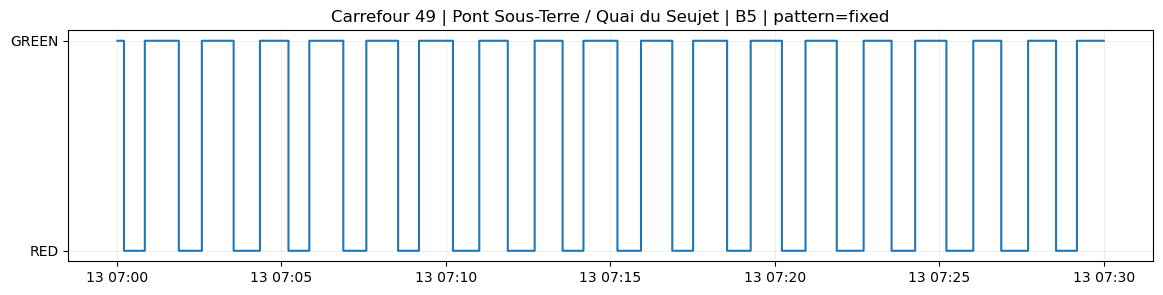

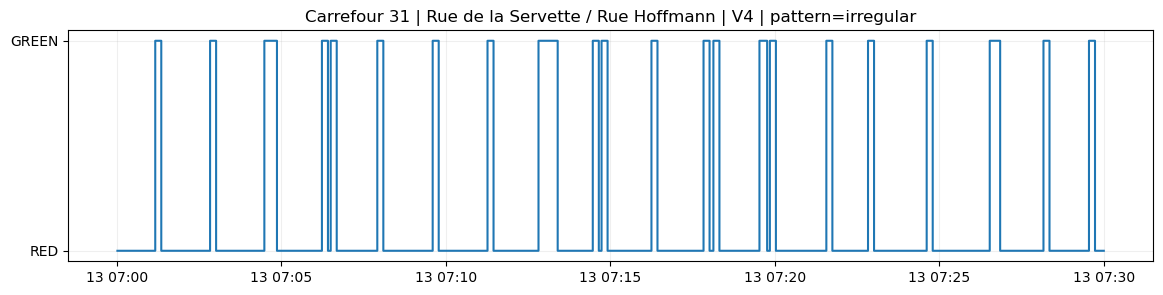

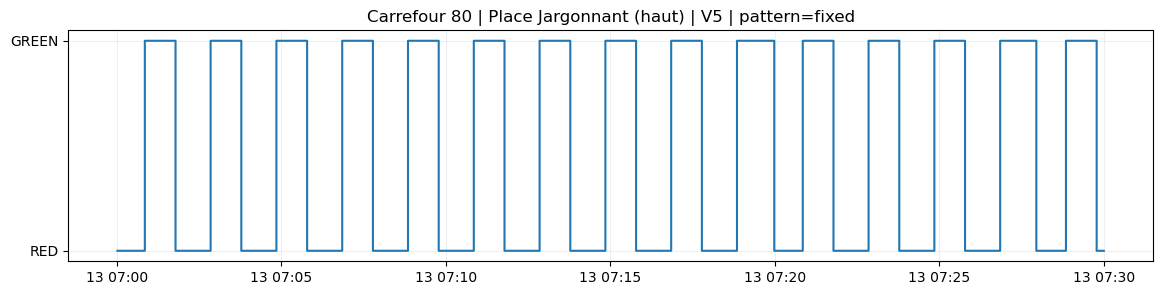

In [24]:
import matplotlib.pyplot as plt

top = summary.sort_values("priority_like_long_green_rate", ascending=False).head(3)
for _, row in top.iterrows():
    p = DB_DIR / f"signal_{int(row.carrefour_id)}.parquet"
    col = row.groupe_de_feux
    df = pd.read_parquet(p, columns=[col])
    s = df[col].astype(int)

    # plot first 30 minutes
    sub = s.iloc[:1800]
    plt.figure(figsize=(14,3))
    plt.step(sub.index, 1 - sub.values, where="post")  # 1=green display, 0=red display
    plt.title(f"Carrefour {row.carrefour_id} | {row.nom_carrefour} | {col} | pattern={row.pattern}")
    plt.yticks([0,1], ["RED","GREEN"])
    plt.grid(True, alpha=0.2)
    plt.show()

In [60]:
# Example Usage inside your feature creation loop:

# 1. Bus is at Segment X.
# 2. Look up 'all_carrefour_merged.csv' -> Found Intersection ID = 17.0 -> int is 17.
# 3. Look up 'groupe_de_feux' -> "T1"

# 4. Load the Signal Data (Cached)
try:
    signals_17 = pd.read_parquet("../data/signal_parquet_db/signal_17.parquet")
    
    # 5. Get the specific column "T1"
    if "T1" in signals_17.columns:
        # 6. Lookup Time
        arrival_time = pd.Timestamp("2025-11-13 08:00:05") # Your calculated arrival
        
        # Use 'asof' to find nearest previous timestamp if exact match missing
        idx = signals_17.index.get_indexer([arrival_time], method='nearest')[0]
        state = signals_17.iloc[idx]["T1"]
        
        print(f"Signal T1 at {arrival_time}: {state} (1=Red, 0=Green)")
        
except FileNotFoundError:
    print("No signal data for this intersection.")

Signal T1 at 2025-11-13 08:00:05: 0 (1=Red, 0=Green)


🎲 Selected Intersection: 15 (signal_15.parquet)
   -> Loaded 14,400 rows (seconds) of data.
   -> Time Range: 2025-11-13 07:00:01 to 2025-11-13 18:00:00
   -> Selected Bus Signal: TX

📊 Quick Stats for TX:
   Green Ratio: 8.0% (Bus has priority 8.0% of the time)


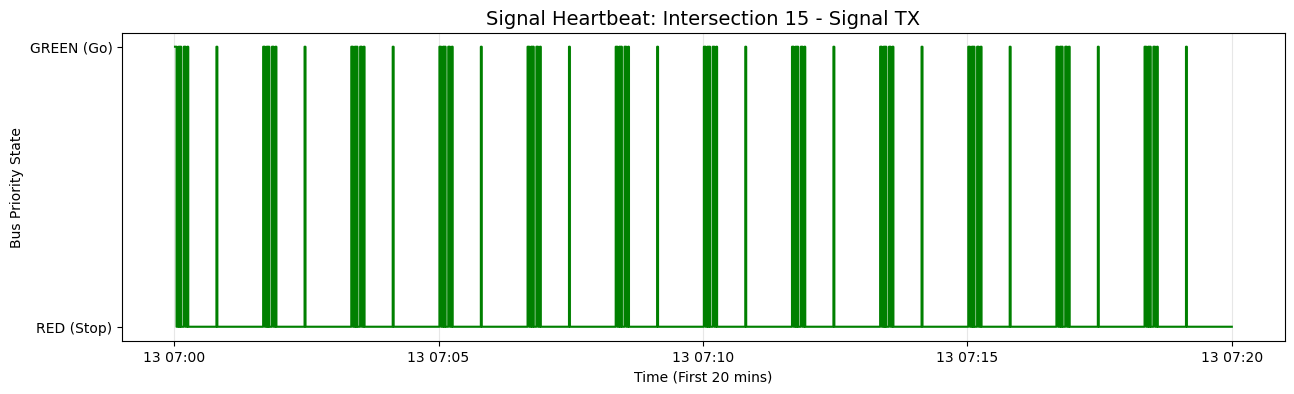

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path

# 1. Locate the Database
DB_PATH = Path("../data/signal_parquet_db")
all_files = list(DB_PATH.glob("*.parquet"))

if not all_files:
    print("❌ No parquet files found in ../data/signal_parquet_db/")
    print("   (Did you run the 'Bulk Processor' script successfully?)")
    
else:
    # 2. Pick a Random Intersection
    random_file = random.choice(all_files)
    intersection_id = random_file.stem.split('_')[1] # 'signal_17' -> '17'
    print(f"🎲 Selected Intersection: {intersection_id} ({random_file.name})")
    
    # 3. Load Data
    df = pd.read_parquet(random_file)
    print(f"   -> Loaded {len(df):,} rows (seconds) of data.")
    print(f"   -> Time Range: {df.index.min()} to {df.index.max()}")
    
    # 4. Pick a Random Signal (Prefer 'T' for Tram/Bus)
    #    Your new parser creates names like 'T1', 'V12'
    bus_signals = [c for c in df.columns if c.startswith('T')]
    
    if bus_signals:
        target_signal = random.choice(bus_signals)
        print(f"   -> Selected Bus Signal: {target_signal}")
    else:
        target_signal = random.choice(df.columns)
        print(f"   -> No 'T' signals found. Selected generic signal: {target_signal}")

    # 5. Visualize the "Heartbeat" (First 20 Minutes)
    #    We slice the first 1200 seconds to see the cycle clearly
    subset = df.iloc[0:1200].copy()
    
    # VISUAL TRICK: Invert the value for plotting.
    # Data: 1 = Red (Stop), 0 = Green (Go)
    # Plot: 0 = Stop, 1 = Go (Intuitive "Activity" Chart)
    plot_data = 1 - subset[target_signal]
    
    plt.figure(figsize=(15, 4))
    
    # Step plot is best for digital signals
    plt.step(subset.index, plot_data, where='post', color='green', linewidth=1.5)
    
    # Fill Green areas
    plt.fill_between(subset.index, plot_data, step='post', color='green', alpha=0.2)
    
    # Formatting
    plt.yticks([0, 1], ['RED (Stop)', 'GREEN (Go)'])
    plt.title(f"Signal Heartbeat: Intersection {intersection_id} - Signal {target_signal}", fontsize=14)
    plt.ylabel("Bus Priority State")
    plt.xlabel("Time (First 20 mins)")
    plt.grid(True, alpha=0.3, axis='x')
    
    # Calculate Stats
    green_ratio = plot_data.mean()
    print(f"\n📊 Quick Stats for {target_signal}:")
    print(f"   Green Ratio: {green_ratio:.1%} (Bus has priority {green_ratio:.1%} of the time)")
    
    plt.show()